# Assignment 4
### Do three of four.

### Exercise 1: Contingent Comparisons
- Load the Minnesota use of force data.
- Bootstrap the proportion of missing values for `subject_injury` for each race, and plot the results with grouped KDE and ECDF plots
- Describe what you see. When we consider second order uncertainty, how similar or different are the sampling distributions of these proportions? 

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
df = pd.read_csv('./data/mn_police_use_of_force.csv')
df.head()

,response_datetime,problem,is_911_call,primary_offense,subject_injury,force_type,force_type_action,race,sex,age,type_resistance,precinct,neighborhood
0,2016/01/01 00:47:36,Assault in Progress,Yes,DASLT1,NaN,Bodily Force,Body Weight to Pin,Black,Male,20.0,Tensed,1,Downtown East
1,2016/01/01 02:19:34,Fight,No,DISCON,NaN,Chemical Irritant,Personal Mace,Black,Female,27.0,Verbal Non-Compliance,1,Downtown West
2,2016/01/01 02:19:34,Fight,No,DISCON,NaN,Chemical Irritant,Personal Mace,White,Female,23.0,Verbal Non-Compliance,1,Downtown West
3,2016/01/01 02:28:48,Fight,No,PRIORI,NaN,Chemical Irritant,Crowd Control Mace,Black,Male,20.0,Commission of Crime,1,Downtown West
4,2016/01/01 02:28:48,Fight,No,PRIORI,NaN,Chemical Irritant,Crowd Control Mace,Black,Male,20.0,Commission of Crime,1,Downtown West


In [3]:
df['injury_na'] = df['subject_injury'].isna() 

In [43]:
df['race'].value_counts()

race
Black                 7648
White                 3129
Native American        784
Other / Mixed Race     205
Asian                  129
Pacific Islander         6
Name: count, dtype: int64

In [26]:
S = 3000
results = []
for s in range(S):
    samp = df.sample(frac=1.0,replace=True) 
    result_s = samp.loc[:,['injury_na','race']].groupby('race').mean() # Compute missing proportions
    results.append(result_s)

estimates = pd.concat([row for row in results],axis=1).T

/var/folders/1z/t_vl0dx95552hzn7xv8z08sm0000gn/T/ipykernel_39074/1172481525.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(estimates)


<Axes: ylabel='Density'>

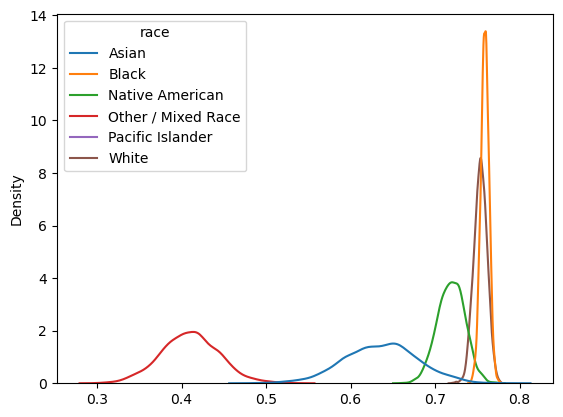

In [27]:
sns.kdeplot(estimates)

We can see that the Black group had the highest density, followed by the White group. The densities from the Asian and Other/Mixed Race groups were wider than the rest, likely due to the fact that they had less observations than the others.  The Pacific Islander group is missing from this plot because its proportion of missing values was 1, which is out of range of this plot.

<Axes: ylabel='Proportion'>

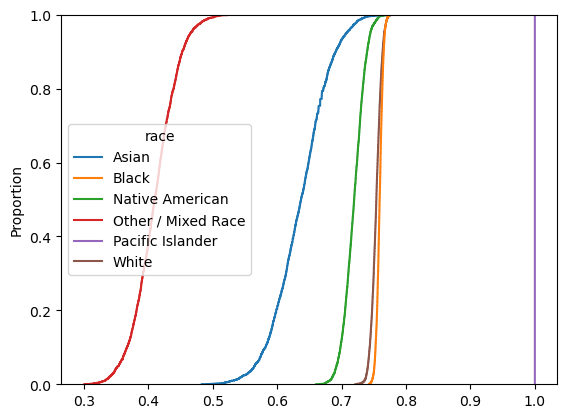

In [28]:
sns.ecdfplot(estimates)

From the ECDF of the estimates, we can see that apart from the Black and White races, which are very similar in the proportion of missing injury values and concentrated at around 0.75, the most concentrated proportion in the estimates varies by a lot. The Other/Mixed Race group has most of its proportions of missing values concentrated at around 0.4, while the Asian group was concentrated at around 0.65, and the Native American group was concentrated around 0.72. The Pacific Islander group is a straight line at 1.0 in this graph because that group had all missing values in the original data.

### Exercise 2: Invitation to Inference
- Run the simulation code line by line and comment what each line is doing, or write your own code to do the resampling
- Open the NHANES or Ames prices or College Completion data. Pick a variable and a statistic to compute (e.g. mean, median, variance, IQR)
- Use the `simulate` function from class to get a sample of estimates for your statistic and your data
- Create a new function, `interval(L,H,estimates)`, that computes the $L$-th and $H$-th quantiles for your estimates, $H>L$
- If $L=.05$ and $H=.95$, this is a **90-percent confidence interval**: "For our statistic, this interval captures the true value of the population parameter 90 percent of the time. (We are 90% **confident** that it includes the true value of the parameter, but the probability that the true parameter lies in this interval is 0 or 1.)"
- We will spend much more time on this later in class, but for people who have done hypothesis testing before, you now know how to do it directly from the data: No central limit theorem required.

In [45]:
df = pd.read_csv('./data/ames_prices.csv')

In [47]:
var = 'area'
S = 2000
estimates = [df[var].sample(frac=1.0,replace=True).mean() for s in range(S)]

In [ ]:
def quantile(data, quantile):
    sorted_data = sorted(data)
    n = len(sorted_data)

    j = int((quantile*n + (1-quantile) - 1) // 1)
    g = int((quantile*n + (1-quantile) - 1) % 1)

    return (1-g)*sorted_data[j] + g*sorted_data[j+1]

In [66]:
def interval(L,H,estimates, plot=True):
    low = quantile(estimates,L)
    high = quantile(estimates,H)
    print(f'Our {str(round((H-L),1)*100)}th percentile confidence interval of {var} is\nLower Bound: {str(low)}\nUpper Bound: {str(high)}')

    if plot == True:
        sns.kdeplot(estimates)
        plt.axvline(x=low,color='purple',linestyle='--')
        plt.axvline(x=high,color='purple',linestyle='--')
    return float(low),float(high)

Our 90.0th percentile confidence interval of area is
Lower Bound: 1484.2822525597269
Upper Bound: 1514.2911262798634


(1484.2822525597269, 1514.2911262798634)

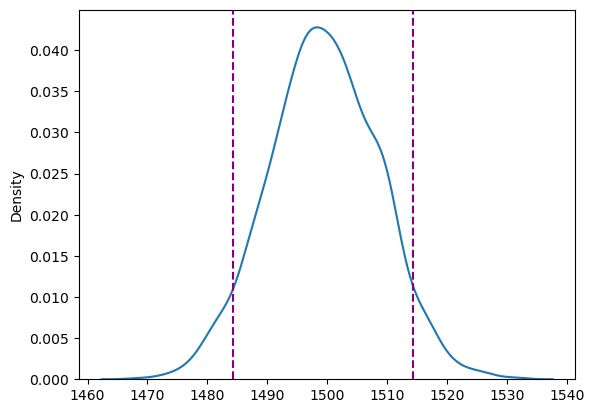

In [67]:
interval(.05,.95,estimates)

### Exercise 3: Intro to A/B Testing
- Go here, and read about this study: https://www.clinicaltrials.gov/study/NCT01985360
- Read the Study Overview and explain what the goal of the trial is 
- Read the Study Plan and explain how it was designed and why -- there's lots of medical jargon, but the main point is how patients were assigned to interventions. 
- Read the Results Posted: Go to **Outcome Measures**. Explain how table 1 ("Incidence of Death from Any Cause or Myocardial Infarction") is a contingency table. These are the data for this exercise.
- What is the difference in surival rates between the invasive strategy and the conservative strategy?
- Bootstrap the survival rates for the two groups, and plot them as KDEs and ECDFs against one another
- Bootstrap the difference in surival rates, and plot it as a KDE and ECDF
- Is this an effective health intervention? Explain your answer clearly

This would be what CS people call **A/B testing** and everyone else called a **randomized controlled trial**: Using randomized assignment to detect the difference in outcomes between two groups. (We've just done a non-parametric version of a two-sample t-test.)

In [9]:
cons_total = 389
cons = np.ones(cons_total)
cons[:129] = 0 

cons = pd.DataFrame({'Group':'Conservative',
                     'Outcome':cons})
cons

inv_total = 388
inv = np.ones(inv_total)
inv[:123] = 0

invs = pd.DataFrame({'Group':'Invasive','Outcome':inv})

In [16]:
c_avg = cons['Outcome'].mean()
i_avg = invs['Outcome'].mean()

In [18]:
float(c_avg - i_avg)

-0.014609227996713714

The difference in survival rates between the invasive and conservative strategies in the original sample is 1.4 percent, with the invasive strategy's survival rate being higher.

In [15]:
S = 2500

c_est = [cons.sample(frac=1.0,replace=True)['Outcome'].mean() for s in range(S)]
i_est = [invs.sample(frac=1.0,replace=True)['Outcome'].mean() for s in range(S)]
est_diff = [c - i for c, i in zip(c_est,i_est)]

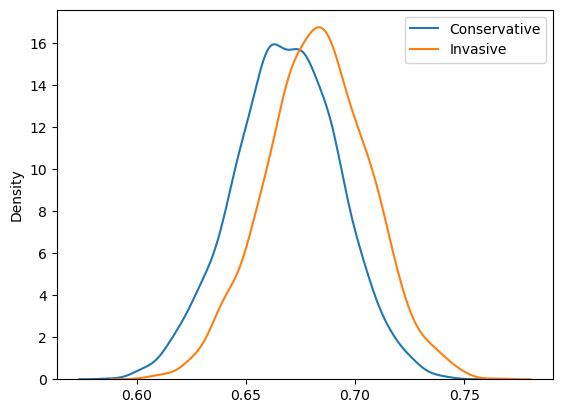

In [23]:
sns.kdeplot(c_est, label='Conservative')
sns.kdeplot(i_est, label='Invasive')
plt.legend()
plt.show()

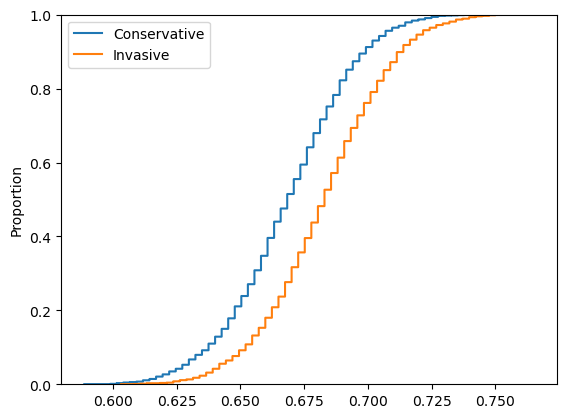

In [24]:
sns.ecdfplot(c_est, label='Conservative')
sns.ecdfplot(i_est, label='Invasive')
plt.legend()
plt.show()

<Axes: ylabel='Density'>

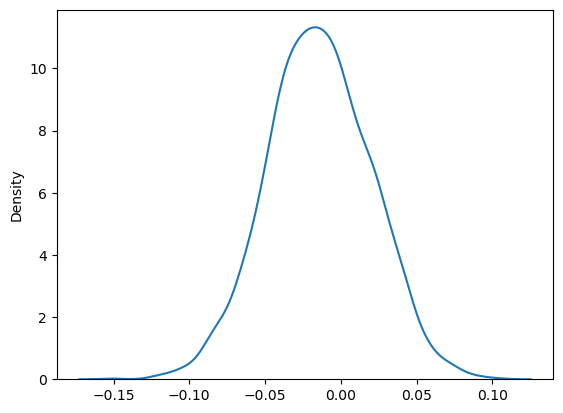

In [25]:
sns.kdeplot(est_diff)

<Axes: ylabel='Proportion'>

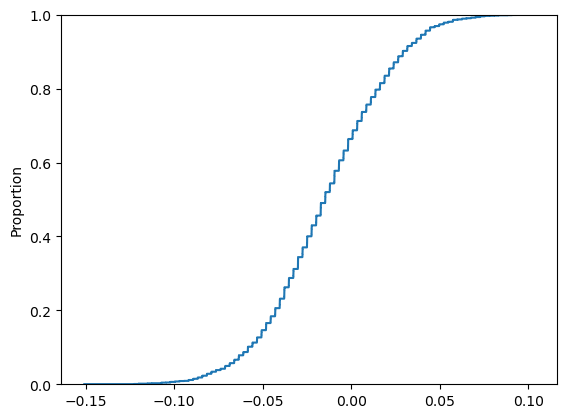

In [26]:
sns.ecdfplot(est_diff)

In [40]:
float(sum([e<0 for e in est_diff])/len(est_diff))*100

66.36

This does not seem to be a very effective health intervention. In the 2500 samples computed, the survival rate for the invasive strategy is only higher in around 66% of the samples, which is not a strong proportion. In the KDE plot, we can see that there is a lot of overlap in the densities of the 2 groups, meaning that their densities are very similar

Both groups, in both the KDE and ECDF plots, seem to have all of their calculated sample survival rates between 60 and 70 percent, which suggests that there is not a meaningful improvement in outcomes when subjects recieved the invasive strategy over the conservative strategy and vice versa.

### Exercise 4: Prediction Uncertainty
- Pick a dataset and two continuous variables.
- Recall the LCLS estimator:
$$
\hat{y}(z) =  \frac{ \frac{1}{N} \sum_{i=1}^N y_i \times \frac{1}{h}k\left( \frac{z - x_i}{h} \right)}{ \frac{1}{N} \sum_{i=1}^N \frac{1}{h} k\left( \frac{z - x_i}{h} \right)}
$$
with the Epanechnikov kernel and the standard plug-in bandwidth for $h$
- Compute and plot this line for 30 bootstrap samples. Notice where there is a lot of variation in the predictions, versus little variation in the predictions.
- Now, for any $z$, we can bootstrap a distribution of predictions using the above formula. Do this at the 25th percentile, median, and 75th percentile of $X$, and make KDE plots of your results.
- Now, pick a grid for $z$: Obvious choices are all of the unique values in the data, or an equally spaced grid from the minimum value to the maximum value. For each $z$, bootstrap a sample of predictions and compute the .05 and .95 quantiles. Plot these error curves along with your LCLS estimate. Where are your predictions "tight"/reliable? Where are they highly variable/unreliable?